# Statistical Modelling

- I will use a hierarchical bayesian linear model like Twieki uses here: https://github.com/github/covid19-dashboard/blob/master/_notebooks/2020-03-16-covid19_growth_bayes.ipynb 

In [1]:
import theano

In [2]:
theano.config.device

'cpu'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [4]:
sns.set_style('whitegrid')

In [5]:
## load the data
df_cases = pd.read_pickle('./corona_scotland_regions_ts.pk')
df_total = pd.read_pickle('./corona_scotland_total_stats.pk')

In [6]:
max_num_days = len(df_cases)
max_num_days

66

In [7]:
df_cases.columns

Index(['Ayrshire and Arran', 'Borders', 'Dumfries and Galloway',
       'Eileanan Siar (Western Isles)', 'Fife', 'Forth Valley', 'Grampian',
       'Greater Glasgow and Clyde', 'Highland', 'Lanarkshire', 'Lothian',
       'Orkney', 'Shetland', 'Tayside', 'Scotland (Total)'],
      dtype='object', name='Health Board')

In [8]:
## remove cases where there are hardly any cases
#drop_cols = df_cases.columns[df_cases.quantile(0.5) == 0.0]
drop_cols = ['Eileanan Siar (Western Isles)', 'Orkney']
print(drop_cols)

df_cases = df_cases.drop(columns=drop_cols)

['Eileanan Siar (Western Isles)', 'Orkney']


In [9]:
regions = df_cases.columns.values[:-1]
n_regions = len(regions)

In [10]:
np.argwhere(df_cases[regions[0]].gt(10).values).ravel()[0]

13

In [11]:
## find starting days
min_cases = 10
starting_days = {r: np.argwhere(df_cases[r].ge(min_cases).values).ravel()[0] for r in regions}
starting_days

{'Ayrshire and Arran': 13,
 'Borders': 15,
 'Dumfries and Galloway': 14,
 'Fife': 14,
 'Forth Valley': 9,
 'Grampian': 7,
 'Greater Glasgow and Clyde': 6,
 'Highland': 17,
 'Lanarkshire': 8,
 'Lothian': 6,
 'Shetland': 8,
 'Tayside': 8}

In [12]:
def doubling_time(r):
    i = 0
    while True:
        x = (1 + r)**i
        if x >= 2:
            break
        else:
            i += 1
    return i, x

In [13]:
rates = [0.33, 0.25, 0.2, 0.17, 0.15, 0.12, 0.10, 0.08, 0.05, 0.02, 0.01]
print('## Doubling Times ##')
for r in rates:
    t, x = doubling_time(r)
    print(f"r={r:.2f}\t=>   {t} days ; (factor={x:.3f})")

## Doubling Times ##
r=0.33	=>   3 days ; (factor=2.353)
r=0.25	=>   4 days ; (factor=2.441)
r=0.20	=>   4 days ; (factor=2.074)
r=0.17	=>   5 days ; (factor=2.192)
r=0.15	=>   5 days ; (factor=2.011)
r=0.12	=>   7 days ; (factor=2.211)
r=0.10	=>   8 days ; (factor=2.144)
r=0.08	=>   10 days ; (factor=2.159)
r=0.05	=>   15 days ; (factor=2.079)
r=0.02	=>   36 days ; (factor=2.040)
r=0.01	=>   70 days ; (factor=2.007)


In [14]:
print(f"{0.1:.5f}")

0.10000


In [15]:
doubling_time(0.25)

(4, 2.44140625)

In [16]:
doubling_time(0.15)

(5, 2.0113571874999994)

In [17]:
doubling_time(0.10)

(8, 2.1435888100000016)

### Whole of Scotland

Text(0, 0.5, 'Num Confirmed Cases')

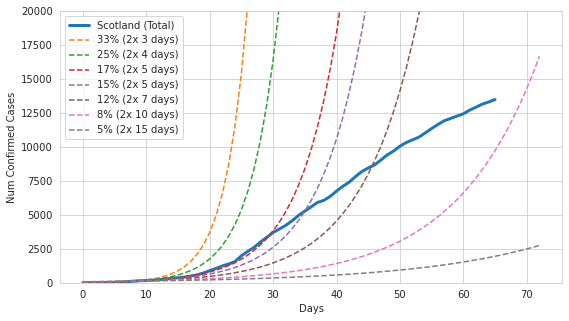

In [18]:
i = 8
max_days = len(df_cases) + 7
c = df_cases['Scotland (Total)'].iloc[i]
df_cases['Scotland (Total)'].reset_index(drop=True)[:].plot(figsize=(9, 5), linewidth=3)
plt.plot(c*(1 + 0.33) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='33% (2x 3 days)')

plt.plot(c*(1 + 0.25) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='25% (2x 4 days)')
plt.plot(c*(1 + 0.17) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='17% (2x 5 days)')
plt.plot(c*(1 + 0.15) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 5 days)')
plt.plot(c*(1 + 0.12) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='12% (2x 7 days)')
plt.plot(c*(1 + 0.08) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='8% (2x 10 days)')
plt.plot(c*(1 + 0.05) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='5% (2x 15 days)')
plt.legend()
plt.ylim(0, 20000)
plt.xlabel('Days')
plt.ylabel('Num Confirmed Cases')

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


Text(0, 0.5, 'Num Confirmed Cases')

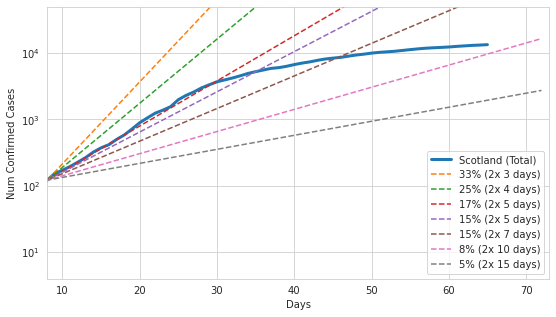

In [19]:
i = 8
c = df_cases['Scotland (Total)'].iloc[i]
df_cases['Scotland (Total)'].reset_index(drop=True)[:].plot(figsize=(9, 5), linewidth=3, logy=True)
plt.plot(c*(1 + 0.33) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='33% (2x 3 days)')

plt.plot(c*(1 + 0.25) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='25% (2x 4 days)')
plt.plot(c*(1 + 0.17) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='17% (2x 5 days)')
plt.plot(c*(1 + 0.15) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 5 days)')
plt.plot(c*(1 + 0.12) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 7 days)')
plt.plot(c*(1 + 0.08) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='8% (2x 10 days)')
plt.plot(c*(1 + 0.05) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='5% (2x 15 days)')
plt.legend()
plt.ylim(0, 50000)
plt.xlim(i, max_days)
plt.xlabel('Days')
plt.ylabel('Num Confirmed Cases')

In [20]:
with pm.Model() as model_scotland:
    
    ### Intercepts ###
    b = pm.Normal('b', 10, 5)
    
    
    ### Slopes ###
    a = pm.Normal('a', 1.12, 0.5)
    
    ### Error ###
    sigma = pm.HalfCauchy('sigma', 50.)
    
    ### Likelihood for Each Region ###
    cases = df_cases['Scotland (Total)'].values[10:]
        
    # From Twieki:
    # By using pm.Data we can change these values after sampling.
    # This allows us to extend x into the future so we can get
    # forecasts by sampling from the posterior predictive
    x = pm.Data('x_data',
                np.arange(10, max_num_days, 1))
    confirmed = pm.Data('y_data',
                        cases)

    # Likelihood
    pm.NegativeBinomial(
        'Scotland (Total)',
        (b * a ** (x-8)), # Exponential regression
        sigma,
        observed=confirmed)

In [21]:
with model_scotland:
    # Sample posterior
    trace_scotland = pm.sample(tune=1000, draws=2000, 
                               chains=2, cores=4, target_accept=0.9,
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, b]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:13<00:00, 443.27draws/s]


In [22]:
with model_scotland:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, max_days)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({'x_data': x_data})
    pm.set_data({'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace_scotland, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:04<00:00, 49.27it/s]


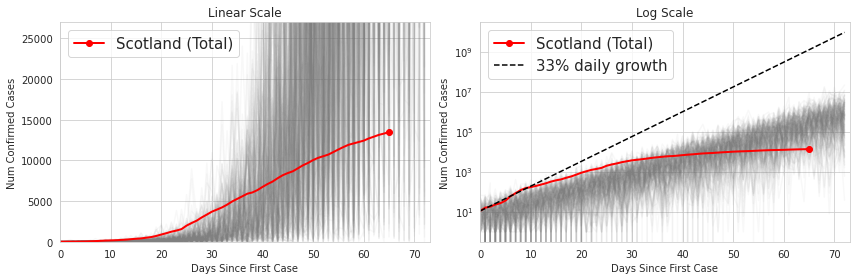

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))
r = 'Scotland (Total)'
y = df_cases[r].iloc[:].values

ax = axes[0]
for sim in post_pred[r]:
    ax.plot(sim, color='gray', alpha=0.05)
ax.plot(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
#ax.plot(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, max_days)
ax.set_ylim(0, 2*y.max())
ax.set_xlabel('Days Since First Case')
ax.set_ylabel('Num Confirmed Cases')
ax.set_title('Linear Scale')
ax.legend(fontsize=15)

ax = axes[1]
for sim in post_pred[r]:
    ax.semilogy(sim, color='gray', alpha=0.05)
ax.semilogy(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
ax.semilogy(y[0] * 1.33 ** np.arange(0, max_days), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, max_days)
ax.set_xlabel('Days Since First Case')
ax.set_ylabel('Num Confirmed Cases')
ax.set_title('Log Scale')
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()

In [24]:
pm.stats.summary(trace_scotland)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,32.113,3.748,25.167,38.882,0.086,0.061,1878.0,1878.0,1880.0,2219.0,1.0
a,1.181,0.010,1.164,1.201,0.000,0.000,1996.0,1990.0,2079.0,1861.0,1.0
sigma,0.644,0.115,0.424,0.851,0.003,0.002,2070.0,2055.0,2081.0,2229.0,1.0


### Create the Model

In [25]:
with pm.Model() as model:
    
    ### Intercepts ###
    # Group mean
    #intr_grp = pm.Normal('intr_grp', 4.3, 2.0)
    intr_grp = 4.3
    # Group variance
    #intr_grp_sigma = pm.HalfNormal('intr_grp_sigma', 2.0)
    intr_grp_sigma = 2.0
    
    # Individual intercepts
    intr_ind = pm.Cauchy('intr_ind',
                          alpha=intr_grp,
                          beta=intr_grp_sigma,
                          shape=n_regions)
    
    
    ### Slopes ###
    # Group mean
    #slope_grp = pm.Normal('slope_grp', 1.13, 0.5)
    slope_grp = 1.06
    # Group variance
    #slope_grp_sigma = pm.HalfNormal('slope_grp_sigma', 0.5)
    slope_grp_sigma = 0.5
    
    # Individual slopes
    slope_ind = pm.Cauchy('slope_ind',
                          alpha=slope_grp,
                          beta=slope_grp_sigma,
                          shape=n_regions)
    
    ### Individual Error ###
    sigma = pm.HalfCauchy('sigma', 50., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        starting_day = starting_days[region]
        cases_region = df_cases[region].values[starting_day:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(starting_day, max_num_days, 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [26]:
with model:
    # Sample posterior
    trace = pm.sample(tune=500, draws=1700, 
                      chains=2, cores=4, target_accept=0.9,
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, slope_ind, intr_ind]
Sampling 2 chains, 0 divergences: 100%|██████████| 4400/4400 [03:51<00:00, 19.01draws/s]
The acceptance probability does not match the target. It is 0.969772508351156, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9767957015588464, but should be close to 0.9. Try to increase the number of tuning steps.


In [27]:
import pickle

In [28]:
#pickle.dump(trace, open('trace_1704.pk', 'wb'))
#pickle.dump(model, open('pymc_model_0904.pk', 'wb'))

In [29]:
with model:
    # Update data so that we get predictions into the future
    for i, r in enumerate(regions):
        #cases_region = df_cases[r].values[starting_days[r]:]
        x_data = np.arange(0, max_days)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({r + 'x_data': x_data})
        pm.set_data({r + 'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


## Predicted Cases By Region

In [30]:
region_loc = {r: i for i,r in enumerate(regions)}

In [31]:
region_loc

{'Ayrshire and Arran': 0,
 'Borders': 1,
 'Dumfries and Galloway': 2,
 'Fife': 3,
 'Forth Valley': 4,
 'Grampian': 5,
 'Greater Glasgow and Clyde': 6,
 'Highland': 7,
 'Lanarkshire': 8,
 'Lothian': 9,
 'Shetland': 10,
 'Tayside': 11}

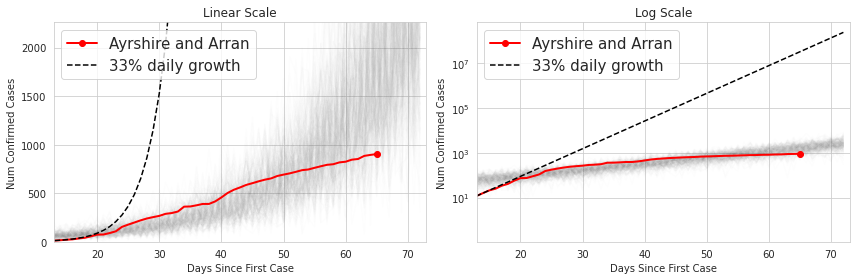

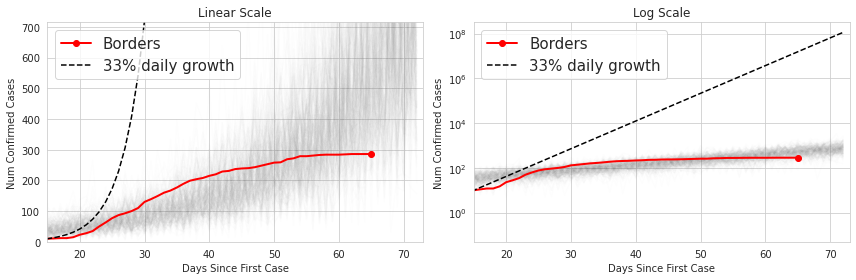

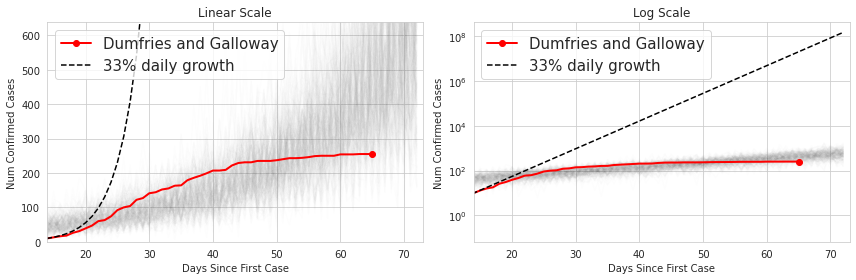

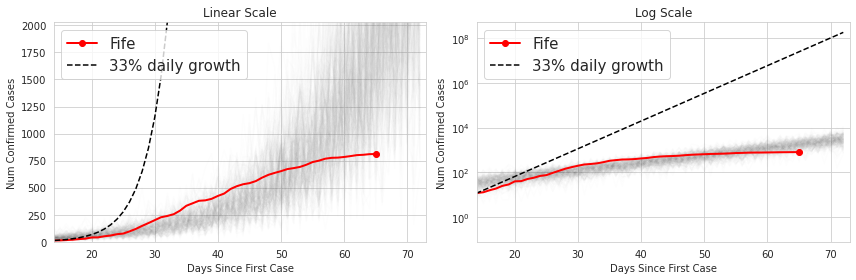

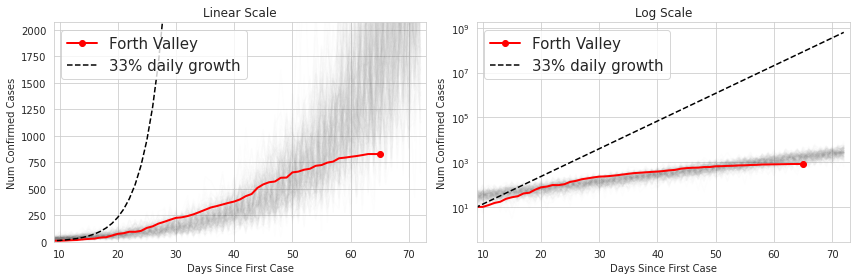

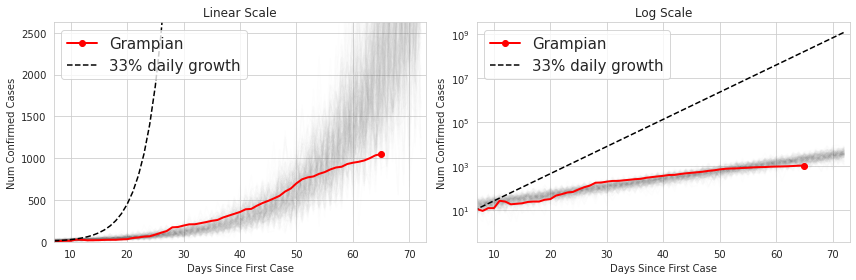

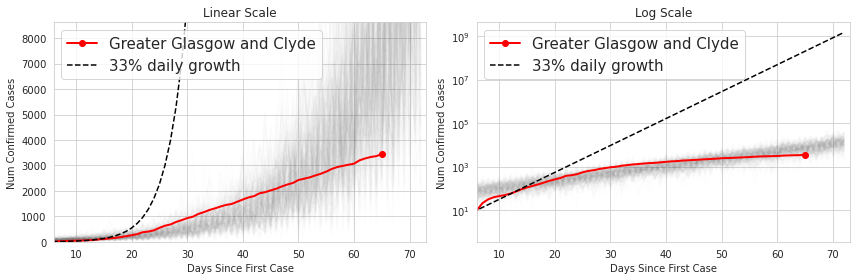

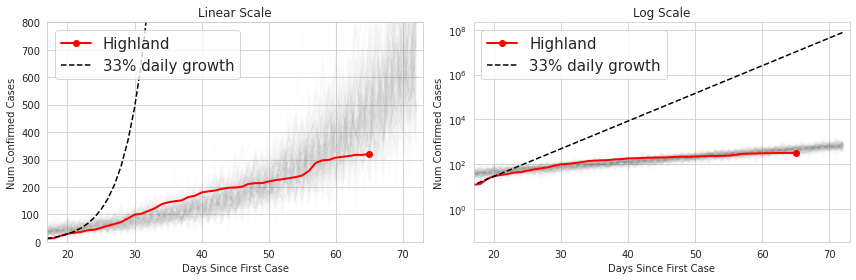

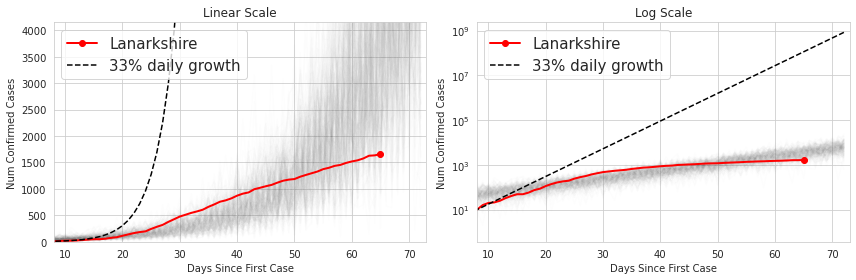

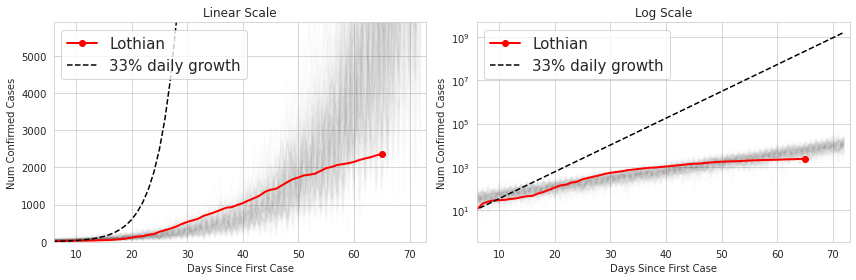

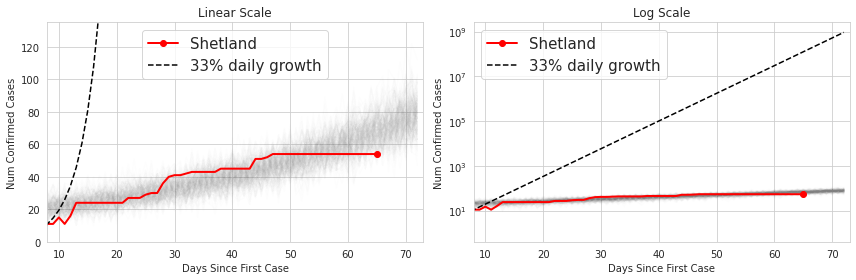

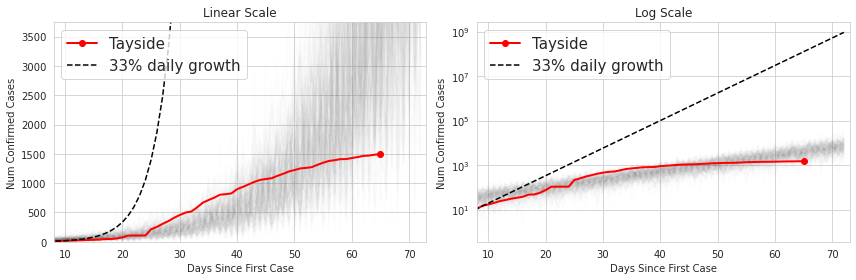

In [32]:
for r in regions:
    y = df_cases[r].iloc[:].values
    start = starting_days[r]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))

    ax = axes[0]
    for sim in post_pred[r]:
        ax.plot(sim, color='gray', alpha=0.01)
    ax.plot(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.plot(y[start] * 1.33 ** (np.arange(0, max_days)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, max_days)
    ax.set_ylim(0, 2.5*max(y))
    ax.set_ylabel('Num Confirmed Cases')
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Linear Scale')
    ax.legend(fontsize=15)

    ax = axes[1]
    for sim in post_pred[r]:
        ax.semilogy(sim, color='gray', alpha=0.01)
    ax.semilogy(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.semilogy(y[start] * 1.33 ** (np.arange(0, max_days)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, max_days)
    ax.set_xlabel('Days Since First Case')
    ax.set_ylabel('Num Confirmed Cases')
    ax.set_title('Log Scale')
    ax.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()
    

## Posterior Growth Rates Per Region

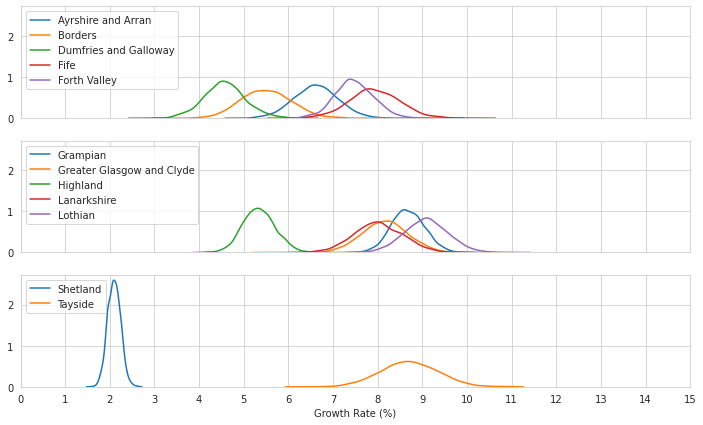

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharey=True, sharex=True)

for i in range(3):
    ax = axes[i]
    ax.grid()
    for r in regions[i*5: (i+1)*5]:
        sns.distplot((trace['slope_ind'][:, region_loc[r]] * 100 - 100), label=r, hist=False, ax=ax)
        ax.legend(loc=2)
        ax.grid()
    
ax.set_xlabel('Growth Rate (%)') 
ax.set_xticks(np.arange(0, 30))
ax.set_xlim(0, 15)
ax.grid()
plt.show()

Confidence intervals of growth rates for each region.

(Orkney and Western Isles ommitted due to lack of data)

In [34]:
for r in regions:
    print(f"{r} : \t{np.mean(trace['slope_ind'][:, region_loc[r]]):.6}  {pm.stats.hpd(trace['slope_ind'][:, region_loc[r]])}")

Ayrshire and Arran : 	1.06621  [1.05685096 1.07559779]
Borders : 	1.055  [1.04457513 1.0653811 ]
Dumfries and Galloway : 	1.0457  [1.03687995 1.05510715]
Fife : 	1.07927  [1.06844688 1.08985149]
Forth Valley : 	1.07476  [1.06729507 1.08354262]
Grampian : 	1.08679  [1.08045849 1.09444009]
Greater Glasgow and Clyde : 	1.08166  [1.07192233 1.09144928]
Highland : 	1.05343  [1.04695132 1.06061533]
Lanarkshire : 	1.08016  [1.07018398 1.09058615]
Lothian : 	1.09088  [1.08114211 1.09985738]
Shetland : 	1.02097  [1.01828744 1.02369247]
Tayside : 	1.0871  [1.07567728 1.09949428]


In [35]:
pm.stats.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intr_ind[0],27.370,5.356,17.688,37.356,0.105,0.076,2599.0,2498.0,2717.0,2234.0,1.0
intr_ind[1],17.879,4.012,10.802,25.512,0.070,0.052,3302.0,2972.0,3481.0,2558.0,1.0
intr_ind[2],25.388,4.795,16.488,34.222,0.103,0.076,2176.0,2014.0,2303.0,1898.0,1.0
intr_ind[3],13.895,3.074,8.774,20.125,0.062,0.047,2426.0,2166.0,2697.0,1937.0,1.0
intr_ind[4],16.862,2.660,11.675,21.678,0.048,0.035,3044.0,2906.0,3135.0,2256.0,1.0
intr_ind[5],9.876,1.332,7.457,12.376,0.025,0.018,2849.0,2737.0,2907.0,2199.0,1.0
intr_ind[6],52.160,9.798,36.074,71.389,0.199,0.153,2433.0,2060.0,2748.0,2109.0,1.0
intr_ind[7],16.453,2.506,11.983,21.175,0.037,0.028,4583.0,4051.0,4728.0,2283.0,1.0
intr_ind[8],27.499,5.467,17.734,37.541,0.112,0.082,2390.0,2223.0,2546.0,2070.0,1.0
intr_ind[9],22.819,3.975,15.749,30.332,0.078,0.056,2614.0,2489.0,2727.0,2080.0,1.0


## Model Diagnostics

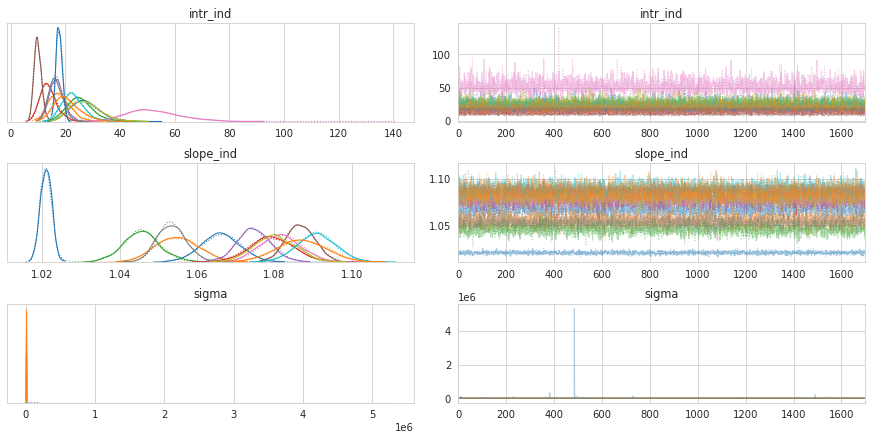

In [36]:
az.plot_trace(trace, compact=True);

In [37]:
19116 + 3000 * 20

79116